In [1]:
# Automatically reload changes to external code
%load_ext autoreload
%autoreload 2

In this assignment, you will solve a classic control problem - CartPole using policy gradient methods.

Policy gradient method is a family of RL algorithms that parameterizes the policy directly. The simplest advantage that policy parameterization may have over action-value parameterization is that the policy may be a simpler function to approximate.

First, you will implement the "vanilla" policy gradient method, i.e., a method that repeatedly computes **unbiased** estimates $\hat{g}$ of $\nabla_{\theta} E[\sum_t r_t]$ and takes gradient ascent steps $\theta \rightarrow \theta + \epsilon \hat{g}$ so as to increase the total rewards collected in each episode. To make sure our code can solve multiple MDPs with different policy parameterizations, provided code follows an OOP manner and represents MDP and Policy as classes.

The following code constructs an instance of the MDP using OpenAI gym.

In [2]:
import gym
import tensorflow as tf
import numpy as np
from policy_gradient import util
from policy_gradient.policy import CategoricalPolicy
from policy_gradient.baselines.linear_feature_baseline import LinearFeatureBaseline

np.random.seed(0)
tf.set_random_seed(0)

# CartPole-v0 is a MDP with finite state and action space. 
# In this environment, A pendulum is attached by an un-actuated joint to a cart, 
# and the goal is to prevent it from falling over. You can apply a force of +1 or -1 to the cart.
# A reward of +1 is provided for every timestep that the pendulum remains upright. 
# To visualize CartPole-v0, please see https://gym.openai.com/envs/CartPole-v0

env = gym.make('CartPole-v0')

[2017-11-07 13:50:11,632] Making new env: CartPole-v0


## Problem 1: construct a neural network to represent policy

Make sure you know how to construct neural network using tensorflow.

1. Open **homework2/policy_gradient/policy.py**.
2. Follow the instruction of Problem 1.

## Problem 2: compute the surrogate loss

If there are $N$ episodes in an iteration, then for $i$ th episode we define $R_t^i = \sum_{{t^′}=t}^T \gamma^{{t^′}-t}r(s_{t^′}, a_{t^′})$ as the accumulated discounted rewards from timestep $t$ to the end of that episode, where $\gamma$ is the discount rate.

The pseudocode for the REINFORCE algorithm is as below:

1. Initialize policy $\pi$ with parameter $\theta_1$.
2. For iteration $k = 1, 2, ...$:
    * Sample N episodes $\tau_1, \tau_2, ..., \tau_N$ under the current policy $\theta_k$, where $\tau_i =(s_i^t,a_i^t,R_i^t)_{t=0}^{T−1}$. Note that the last state is dropped since no action is taken after observing the last state.
    * Compute the empirical policy gradient using formula: $$\hat{g} = E_{\pi_\theta}[\nabla_{\theta} log\pi_\theta(a_t^i | s_t^i) R_t^i]$$
    * Take a gradient step: $\theta_{k+1} = \theta_k + \epsilon \hat{g}$.
    
    
Note that we can transform the policy gradient formula as

$$\hat{g} = \nabla_{\theta} \frac{1}{(NT)}(\sum_{i=1}^N \sum_{t=0}^T log\pi_\theta(a_t^i | s_t^i) *R_t^i)$$

and $L(\theta) = \frac{1}{(NT)}(\sum_{i=1}^N \sum_{t=0}^T log\pi_\theta(a_t^i | s_t^i) *R_t^i)$ is called the surrogate loss. 

We can first construct the computation graph for $L(\theta)$, and then take its gradient as the empirical policy gradient.


1. Open **homework2/policy_gradient/policy.py**.
2. Follow the instruction of Problem 2.

In [3]:
tf.reset_default_graph()
sess = tf.Session()
# Construct a neural network to represent policy which maps observed state to action. 
in_dim = util.flatten_space(env.observation_space)
out_dim = util.flatten_space(env.action_space)
hidden_dim = 8

# Initialize your policy
with tf.variable_scope("policy"):
    opt_p = tf.train.AdamOptimizer(learning_rate=0.01)
    policy = CategoricalPolicy(in_dim, out_dim, hidden_dim, opt_p, sess)


/Users/Howard/anaconda/envs/cedl/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### Problem 3

Use baseline to reduce the variance of our gradient estimate.

Change the loss term: 

$$L(\theta) = \frac{1}{(NT)}(\sum_{i=1}^N \sum_{t=0}^T log\pi_\theta(a_t^i | s_t^i) *R_t^i)$$

into this one

$$L(\theta) = \frac{1}{(NT)}(\sum_{i=1}^N \sum_{t=0}^T log\pi_\theta(a_t^i | s_t^i) *(R_t^i-V_t^i))$$

where $V_t^i$ is the baseline prediction for at the $t$ timestep $i^{th}$ trajectory. In this part, we use a simple linear function to parameterize value function. (You're encouraged to see the details in ```policy_gradient/baselines/linear_feature_baseline.py```)

1. Fill in the function `process_paths` of class `PolicyOptimizer` below.

In [4]:
class PolicyOptimizer(object):
    def __init__(self, env, policy, baseline, n_iter, n_episode, path_length,
        discount_rate=.99):

        self.policy = policy
        self.baseline = baseline
        self.env = env
        self.n_iter = n_iter
        self.n_episode = n_episode
        self.path_length = path_length
        self.discount_rate = discount_rate

    def sample_path(self):
        obs = []
        actions = []
        rewards = []
        ob = self.env.reset()

        # sample a batch of trajectory
        for _ in range(self.path_length):
            a = self.policy.act(ob.reshape(1, -1))
            next_ob, r, done, _ = self.env.step(a)
            obs.append(ob)
            actions.append(a)
            rewards.append(r)
            ob = next_ob
            if done:
                break

        return dict(
            observations=np.array(obs),
            actions=np.array(actions),
            rewards=np.array(rewards),
        )

    def process_paths(self, paths):
        for p in paths:
            if self.baseline != None:
                b = self.baseline.predict(p)
                b[-1] = 0 # terminal state
            else:
                b = 0
            
            # `p["rewards"]` is a matrix contains the rewards of each timestep in a sample path
            r = util.discount_cumsum(p["rewards"], self.discount_rate)
            
            """
            Problem 3:

            1. Variable `b` is the values predicted by our baseline
            2. Use it to reduce variance and then assign the result to the 
                    variable `a` (baseline reduction)

            Sample solution should be only 1 line.
            """
            # YOUR CODE HERE >>>>>>
            a = r - b
            # <<<<<<<<

            p["returns"] = r
            p["baselines"] = b
            p["advantages"] = (a - a.mean()) / (a.std() + 1e-8) # normalize
            p["advantage_variance"] = np.var(a) # My additional code for plotting advantage variance.
            
        obs = np.concatenate([ p["observations"] for p in paths ])
        actions = np.concatenate([ p["actions"] for p in paths ])
        rewards = np.concatenate([ p["rewards"] for p in paths ])
        advantages = np.concatenate([ p["advantages"] for p in paths ])
        advantage_variances = np.array([ p["advantage_variance"] for p in paths ])

        return dict(
            observations=obs,
            actions=actions,
            rewards=rewards,
            advantage_variances=advantage_variances,
            advantages=advantages,
        )

    
    def train(self):
        loss_list = []
        avg_return_list = []
        avg_advantage_variance_list = []
        
        for i in range(1, self.n_iter + 1):
            paths = []
            
            for _ in range(self.n_episode):
                paths.append(self.sample_path())
                
            data = self.process_paths(paths)
            loss = self.policy.train(data["observations"], data["actions"], data["advantages"])
            avg_return = np.mean([sum(p["rewards"]) for p in paths])
            avg_advantage_variance = np.mean(data["advantage_variances"])
            
            print("Iteration {}: Average Return = {} | Average Advantage Variance: {}".format(i, avg_return, avg_advantage_variance))
            
            loss_list.append(loss)
            avg_return_list.append(avg_return)
            avg_advantage_variance_list.append(avg_advantage_variance)
            
            # CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials.
            if avg_return >= 195:
                print("Solve at {} iterations, which equals {} episodes.".format(i, i*100))
                break

            if self.baseline != None:
                self.baseline.fit(paths)
        return loss_list, avg_return_list, avg_advantage_variance_list

In [5]:
sess.run(tf.global_variables_initializer())

n_iter = 200
n_episode = 100
path_length = 200
discount_rate = 0.99
baseline = LinearFeatureBaseline(env.spec)

po = PolicyOptimizer(env, policy, baseline, n_iter, n_episode, path_length,
                     discount_rate)

# Train the policy optimizer
loss_list, avg_return_list, avg_advantage_variance_list = po.train()

Iteration 1: Average Return = 25.59 | Average Advantage Variance: 48.351865612557724
Iteration 2: Average Return = 24.8 | Average Advantage Variance: 20.65048949168897
Iteration 3: Average Return = 28.74 | Average Advantage Variance: 22.13545724245825
Iteration 4: Average Return = 30.85 | Average Advantage Variance: 21.29429545367064
Iteration 5: Average Return = 31.25 | Average Advantage Variance: 23.602730478502558
Iteration 6: Average Return = 35.95 | Average Advantage Variance: 30.556859174015543
Iteration 7: Average Return = 33.98 | Average Advantage Variance: 34.52406210704295
Iteration 8: Average Return = 34.02 | Average Advantage Variance: 26.42146686387153
Iteration 9: Average Return = 37.86 | Average Advantage Variance: 28.0064356959493
Iteration 10: Average Return = 36.7 | Average Advantage Variance: 29.125894655094726
Iteration 11: Average Return = 39.24 | Average Advantage Variance: 34.92325058502597
Iteration 12: Average Return = 38.12 | Average Advantage Variance: 24.663

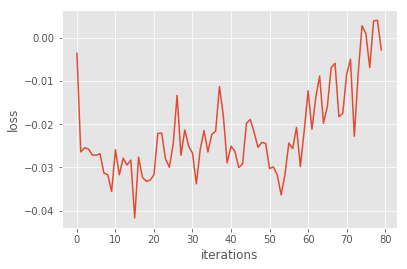

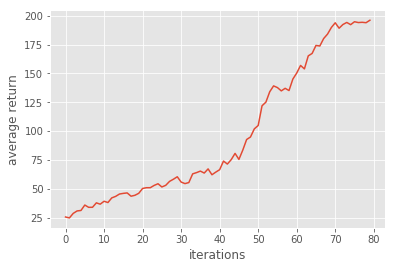

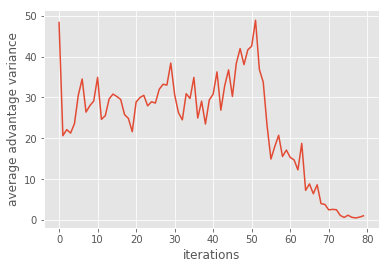

In [6]:
util.plot_curve(loss_list, "loss")
util.plot_curve(avg_return_list, "average return")
util.plot_curve(avg_advantage_variance_list, "average advantage variance")

# Verify your solutions

if you solve the problems 1~3 correctly, your will solve CartPole with roughly ~ 80 iterations.

# Problem 4

Replacing line 

`baseline = LinearFeatureBaseline(env.spec)` 

with 

`baseline = None`

can remove the baseline.

Modify the code to compare the variance and performance before and after adding baseline. And explain why the baseline won't introduce bias. Then, write a report about your findings and explainations. 

In [7]:
sess.run(tf.global_variables_initializer())

n_iter = 200
n_episode = 100
path_length = 200
discount_rate = 0.99
baseline = None

po = PolicyOptimizer(env, policy, baseline, n_iter, n_episode, path_length,
                     discount_rate)

# Train the policy optimizer
loss_list_without_baseline, avg_return_list_without_baseline, avg_advantage_variance_list_without_baseline = po.train()

Iteration 1: Average Return = 15.07 | Average Advantage Variance: 17.98873525729186
Iteration 2: Average Return = 17.27 | Average Advantage Variance: 24.259566651949285
Iteration 3: Average Return = 19.4 | Average Advantage Variance: 30.39233750543137
Iteration 4: Average Return = 20.87 | Average Advantage Variance: 34.60069318204511
Iteration 5: Average Return = 19.82 | Average Advantage Variance: 31.314898097805916
Iteration 6: Average Return = 22.94 | Average Advantage Variance: 40.7568094184233
Iteration 7: Average Return = 22.28 | Average Advantage Variance: 37.74998250285457
Iteration 8: Average Return = 22.94 | Average Advantage Variance: 38.78101747563966
Iteration 9: Average Return = 25.12 | Average Advantage Variance: 45.761837500421606
Iteration 10: Average Return = 27.19 | Average Advantage Variance: 52.82168922122262
Iteration 11: Average Return = 28.93 | Average Advantage Variance: 59.846480706886176
Iteration 12: Average Return = 28.39 | Average Advantage Variance: 56.64

Iteration 97: Average Return = 169.86 | Average Advantage Variance: 524.5263287282062
Iteration 98: Average Return = 176.71 | Average Advantage Variance: 539.9921097000191
Iteration 99: Average Return = 174.43 | Average Advantage Variance: 535.058614025152
Iteration 100: Average Return = 176.2 | Average Advantage Variance: 539.0051666387105
Iteration 101: Average Return = 185.43 | Average Advantage Variance: 560.1852420366822
Iteration 102: Average Return = 187.21 | Average Advantage Variance: 563.3867450825511
Iteration 103: Average Return = 185.87 | Average Advantage Variance: 563.1198251073577
Iteration 104: Average Return = 190.54 | Average Advantage Variance: 573.1258449778474
Iteration 105: Average Return = 190.25 | Average Advantage Variance: 572.3870107768262
Iteration 106: Average Return = 190.91 | Average Advantage Variance: 573.6210221642276
Iteration 107: Average Return = 186.53 | Average Advantage Variance: 562.7784407716526
Iteration 108: Average Return = 187.37 | Average

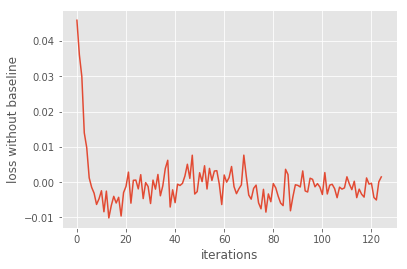

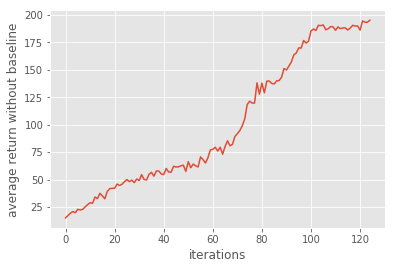

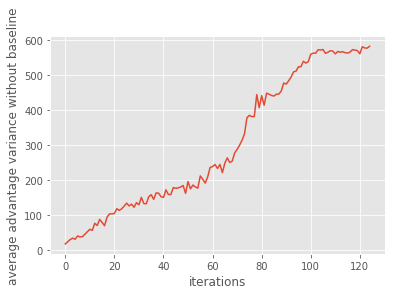

In [8]:
util.plot_curve(loss_list_without_baseline, "loss without baseline")
util.plot_curve(avg_return_list_without_baseline, "average return without baseline")
util.plot_curve(avg_advantage_variance_list_without_baseline, "average advantage variance without baseline")

# Problem 5: Actor-Critic algorithm (with bootstrapping)

The baseline reduction lowers the variance without the cost of introducing bias. Are there any others that can reduce the variance of the policy?

In this part, you will implement a simple actor-critic algorithm. Try to overwrite the `process_paths` in `PolicyOptimizer_actor_critic`. Note that the `PolicyOptimizer_actor_critic` inherit the class `PolicyOptimizer`


We use the one-step bootstrap for the advantage function, which change the $A_t^i=(R_t^i-V_t^i)$ in problem 3 into:

$$A_t^i = r_t^i + \gamma*V_{t+1}^i - V_t^i$$

Open **policy_gradient/util.py ** to implement the function `discount_bootstrap`

If you answer is right, your will solve CartPole with roughly ~ 80 iterations.

In [9]:
# set the hyperparameter for generalized advantage estimation (GAE)
LAMBDA = 0.98 # \lambda
class PolicyOptimizer_actor_critic(PolicyOptimizer):
    def __init__(self, env, policy, baseline, n_iter, n_episode, path_length,
        discount_rate=.99):
        PolicyOptimizer.__init__(self, env, policy, baseline, n_iter, n_episode, path_length,
            discount_rate=.99)
    
    def process_paths(self, paths):
        for p in paths:
            if self.baseline != None:
                b = self.baseline.predict(p)
                b[-1] = 0 # terminal state
            else:
                b = 0
            
            """
            1. Variable `b` is the reward predicted by our baseline
            2. Calculate the advantage function via one-step bootstrap
                    A(s, a) = [r(s,a,s') + \gamma*v(s')] - v(s)
            3. `target_v` specifies the target of the baseline function
            """
            r = util.discount_bootstrap(p["rewards"], self.discount_rate, b)
            target_v = util.discount_cumsum(p["rewards"], self.discount_rate)
            a = r - b
                        
            p["returns"] = target_v
            p["baselines"] = b
            p["advantages"] = (a - a.mean()) / (a.std() + 1e-8) # normalize
            p["advantage_variance"] = np.var(a) # My additional code for plotting advantage variance.

        obs = np.concatenate([ p["observations"] for p in paths ])
        actions = np.concatenate([ p["actions"] for p in paths ])
        rewards = np.concatenate([ p["rewards"] for p in paths ])
        advantages = np.concatenate([ p["advantages"] for p in paths ])
        advantage_variances = np.array([ p["advantage_variance"] for p in paths ])

        return dict(
            observations=obs,
            actions=actions,
            rewards=rewards,
            advantages=advantages,
            advantage_variances=advantage_variances
        )

In [10]:
sess.run(tf.global_variables_initializer())

n_iter = 200
n_episode = 100
path_length = 200
discount_rate = 0.99
# reinitialize the baseline function
baseline = LinearFeatureBaseline(env.spec) 
sess.run(tf.global_variables_initializer())
po = PolicyOptimizer_actor_critic(env, policy, baseline, n_iter, n_episode, path_length,
                     discount_rate)

# Train the policy optimizer
loss_list, avg_return_list, avg_advantage_variance_list  = po.train()

Iteration 1: Average Return = 22.2 | Average Advantage Variance: 0.0
Iteration 2: Average Return = 21.61 | Average Advantage Variance: 2.618711848254234
Iteration 3: Average Return = 23.1 | Average Advantage Variance: 1.6063604018694964
Iteration 4: Average Return = 23.73 | Average Advantage Variance: 1.6772316325092151
Iteration 5: Average Return = 25.26 | Average Advantage Variance: 1.974914730986716
Iteration 6: Average Return = 27.16 | Average Advantage Variance: 1.9638738826857867
Iteration 7: Average Return = 29.46 | Average Advantage Variance: 2.752185232343
Iteration 8: Average Return = 31.67 | Average Advantage Variance: 2.629188374708864
Iteration 9: Average Return = 31.46 | Average Advantage Variance: 2.9513828524634333
Iteration 10: Average Return = 35.63 | Average Advantage Variance: 2.033179000863392
Iteration 11: Average Return = 38.5 | Average Advantage Variance: 2.8707111426854315
Iteration 12: Average Return = 32.51 | Average Advantage Variance: 4.274929735704571
Iter

Iteration 97: Average Return = 144.54 | Average Advantage Variance: 0.7622247405890629
Iteration 98: Average Return = 137.01 | Average Advantage Variance: 0.7156952549156059
Iteration 99: Average Return = 138.43 | Average Advantage Variance: 0.7426439940438947
Iteration 100: Average Return = 151.15 | Average Advantage Variance: 1.0073336471407874
Iteration 101: Average Return = 161.88 | Average Advantage Variance: 0.6208734443790099
Iteration 102: Average Return = 167.13 | Average Advantage Variance: 0.5069164085843254
Iteration 103: Average Return = 166.72 | Average Advantage Variance: 0.4812595651801905
Iteration 104: Average Return = 165.26 | Average Advantage Variance: 0.5982363819871821
Iteration 105: Average Return = 160.76 | Average Advantage Variance: 0.5328720201851901
Iteration 106: Average Return = 161.03 | Average Advantage Variance: 0.6354634235509983
Iteration 107: Average Return = 152.72 | Average Advantage Variance: 0.6312697928647074
Iteration 108: Average Return = 144

Iteration 191: Average Return = 181.72 | Average Advantage Variance: 0.3973691078990239
Iteration 192: Average Return = 182.9 | Average Advantage Variance: 0.2939822335636896
Iteration 193: Average Return = 180.39 | Average Advantage Variance: 0.3127256627043685
Iteration 194: Average Return = 184.88 | Average Advantage Variance: 0.2979888181824994
Iteration 195: Average Return = 184.91 | Average Advantage Variance: 0.39057182841201565
Iteration 196: Average Return = 182.3 | Average Advantage Variance: 0.35510879795742
Iteration 197: Average Return = 186.67 | Average Advantage Variance: 0.34924674040547965
Iteration 198: Average Return = 188.83 | Average Advantage Variance: 0.39613644184273566
Iteration 199: Average Return = 181.39 | Average Advantage Variance: 0.40448112973191436
Iteration 200: Average Return = 180.25 | Average Advantage Variance: 0.4814011798512973


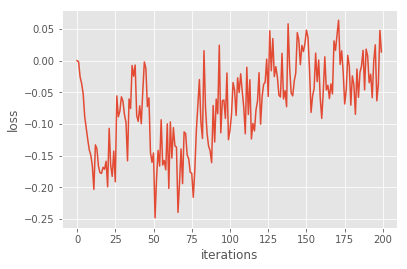

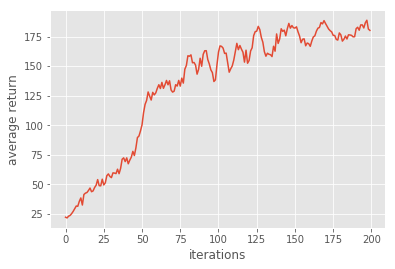

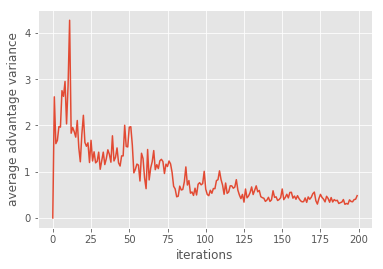

In [11]:
util.plot_curve(loss_list, "loss")
util.plot_curve(avg_return_list, "average return")
util.plot_curve(avg_advantage_variance_list, "average advantage variance")

# Problem 6: Generalized Advantage Estimation

In Problem 3, we calculate the advantage function with **the total return substract the baseline** 

In Problem 5, we calculate the advantage function based on Problem 3, and **replace the total return with the immediate reward plus estimated baseline**

Here, we use a novel advantage function called "Generalized Advantage Estimation", which introduces one hyperparameter $\lambda$ to compromise the above two estimation methods.

Assume the $\delta_t^i$ represent the i-step bootstrapping (e.g. $\delta_t^i=r_t^i + \gamma*V_{t+1}^i - V_t^i$). The generalized advantage estimation will be:

$$A_{t}^{GAE} = \sum_{l=0}^{\infty} (\gamma\lambda)^l \delta_{t+1}$$

Please see [High-Dimensional Continuous Control Using Generalized Advantage Estimation](https://arxiv.org/abs/1506.02438) for details.


If you answer is right, your will solve CartPole with roughly ~ 80 iterations.

In [12]:
# set the hyperparameter for generalized advantage estimation (GAE)
LAMBDA = 0.98 # \lambda
class PolicyOptimizer_actor_critic(PolicyOptimizer):
    def __init__(self, env, policy, baseline, n_iter, n_episode, path_length,
        discount_rate=.99):
        PolicyOptimizer.__init__(self, env, policy, baseline, n_iter, n_episode, path_length,
            discount_rate=.99)
    
    def process_paths(self, paths):
        for p in paths:
            if self.baseline != None:
                b = self.baseline.predict(p)
                b[-1] = 0 # terminal state
            else:
                b = 0
            
            """
            1. Variable `b` is the reward predicted by our baseline
            2. Calculate the advantage function via one-step bootstrap
                    A(s, a) = [r(s,a,s') + \gamma*v(s')] - v(s)
            3. `target_v` specifies the target of the baseline function
            """
            r = util.discount_bootstrap(p["rewards"], self.discount_rate, b)
            target_v = util.discount_cumsum(p["rewards"], self.discount_rate)
            a = r - b
            
            """
            Problem 6 (Skip this when doing Proble): 
            
            1. in Problem 3, we calculate the advantage function with the total 
                       return substract the baseline 
               in Problem 5, we calculate the advantage function based on Problem 3. 
                       And replace the total return with the immediate reward plus estimated baseline
            2. Here, we use a novel advantage function called "Generalized Advantage Estimation", 
                       which introduces one hyperparameter to balance the above two estimation methods.
            Currently, the variable `LAMBDA` is the default hyperparameter for GAE. 
                        (You're encouraged to try other \lambda=[0,1])
            Sample solution should be only 1 line. (you can use `util.discount` in policy_gradient/util.py)
            """
            
            # YOUR CODE HERE >>>>>>>>
            a = util.discount(a, self.discount_rate * LAMBDA)
            # <<<<<<<
            
            p["returns"] = target_v
            p["baselines"] = b
            p["advantages"] = (a - a.mean()) / (a.std() + 1e-8) # normalize
            p["advantage_variance"] = np.var(a) # My additional code for plotting advantage variance.

        obs = np.concatenate([ p["observations"] for p in paths ])
        actions = np.concatenate([ p["actions"] for p in paths ])
        rewards = np.concatenate([ p["rewards"] for p in paths ])
        advantages = np.concatenate([ p["advantages"] for p in paths ])
        advantage_variances = np.array([ p["advantage_variance"] for p in paths ])

        return dict(
            observations=obs,
            actions=actions,
            rewards=rewards,
            advantages=advantages,
            advantage_variances=advantage_variances
        )

In [13]:
sess.run(tf.global_variables_initializer())

n_iter = 200
n_episode = 100
path_length = 200
discount_rate = 0.99
# reinitialize the baseline function
baseline = LinearFeatureBaseline(env.spec) 
sess.run(tf.global_variables_initializer())
po = PolicyOptimizer_actor_critic(env, policy, baseline, n_iter, n_episode, path_length,
                     discount_rate)

# Train the policy optimizer
loss_list, avg_return_list, avg_advantage_variance_list  = po.train()

Iteration 1: Average Return = 29.49 | Average Advantage Variance: 28.872314758080293
Iteration 2: Average Return = 28.15 | Average Advantage Variance: 17.206342272832206
Iteration 3: Average Return = 27.0 | Average Advantage Variance: 12.806761327170523
Iteration 4: Average Return = 32.44 | Average Advantage Variance: 15.634516310988477
Iteration 5: Average Return = 34.46 | Average Advantage Variance: 20.01783041624987
Iteration 6: Average Return = 37.53 | Average Advantage Variance: 21.310244541815788
Iteration 7: Average Return = 38.8 | Average Advantage Variance: 17.76565792390446
Iteration 8: Average Return = 39.93 | Average Advantage Variance: 15.314962409840621
Iteration 9: Average Return = 44.31 | Average Advantage Variance: 17.46989303925956
Iteration 10: Average Return = 45.95 | Average Advantage Variance: 18.05843269318995
Iteration 11: Average Return = 53.0 | Average Advantage Variance: 17.74426220546417
Iteration 12: Average Return = 49.09 | Average Advantage Variance: 17.7

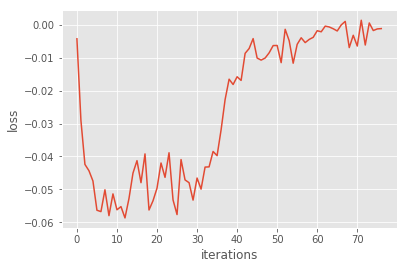

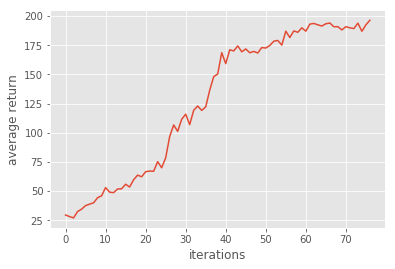

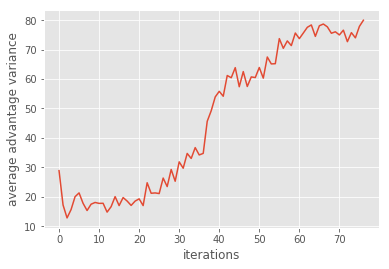

In [14]:
util.plot_curve(loss_list, "loss")
util.plot_curve(avg_return_list, "average return")
util.plot_curve(avg_advantage_variance_list, "average advantage variance")